In [6]:
from pathlib import Path

project_dir = Path('.').absolute().parent
project_dir

PosixPath('/home/daniel/Documents/github/mcx-lab/rl-baselines3-zoo')

In [7]:
import gym
import utils.import_envs

env = gym.make('A1GymEnv-v0', gait_name='trot')
env.observation_space.shape
print(env.all_sensors())
foot_names = env.robot.GetFootNames()
print(foot_names)

Init CPG gait=trot, duty_factor=0.5, period=0.6666666666666666
argv[0]=
[<blind_walking.envs.sensors.robot_sensors.BaseVelocitySensor object at 0x7fac440722b0>, <blind_walking.envs.sensors.robot_sensors.IMUSensor object at 0x7fac44072520>, <blind_walking.envs.sensors.robot_sensors.MotorAngleSensor object at 0x7fac44072610>, <blind_walking.envs.sensors.robot_sensors.MotorVelocitySensor object at 0x7fac440722e0>, <blind_walking.envs.sensors.environment_sensors.LastActionSensor object at 0x7fac44072550>, <blind_walking.envs.sensors.environment_sensors.ForwardTargetPositionSensor object at 0x7fac440725e0>, <blind_walking.envs.sensors.cpg_sensors.ReferenceGaitSensor object at 0x7fac44072580>]
['FR_toe_fixed', 'FL_toe_fixed', 'RR_toe_fixed', 'RL_toe_fixed']


/home/daniel/anaconda3/envs/rl-baselines-zoo-cu113/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


# Inspect logged inputs / outputs

Logs generated with `scripts/enjoy_with_logging.py`

In [8]:
import numpy as np
import pickle 

def load_robot_states(stats_dir):
    motor_position = np.load(stats_dir / 'motor_position.npy')
    print(motor_position.shape)
    motor_velocity = np.load(stats_dir / 'motor_velocity.npy')
    feet_air_time = np.load(stats_dir / 'feet_air_time.npy')
    print(feet_air_time.shape)
    nn_observations = np.load(stats_dir / 'nn_observations.npy')
    print(nn_observations.shape)
    nn_actions = np.load(stats_dir / 'nn_actions.npy')
    print(nn_actions.shape)
    time = np.load(stats_dir / 'time.npy')
    
    return time, motor_position, motor_velocity, feet_air_time, nn_observations, nn_actions

def load_normalizer(model_dir):
    with open(model_dir / 'A1GymEnv-v0' / 'vecnormalize.pkl', 'rb') as file:
        normalizer = pickle.load(file)
    return normalizer

(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 50)
(1000, 1, 12)
[46.00000006 45.99999874 45.99999874 46.00000006]
[46.00000006 45.99999874 45.99999874 46.00000006]
[46.00000006 45.49999876 45.49999876 46.00000006]
[47.00000006 46.49999873 46.49999873 47.00000006]


[47.00000006 47.4999987  47.4999987  47.00000006]
[49.00000006 48.49999868 48.49999868 49.00000006]
[50.00000006 50.49999862 50.49999862 50.00000006]


[57.00000007 56.49999846 56.49999846 57.00000007]


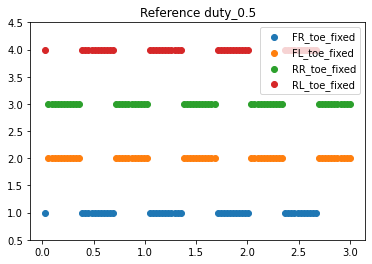

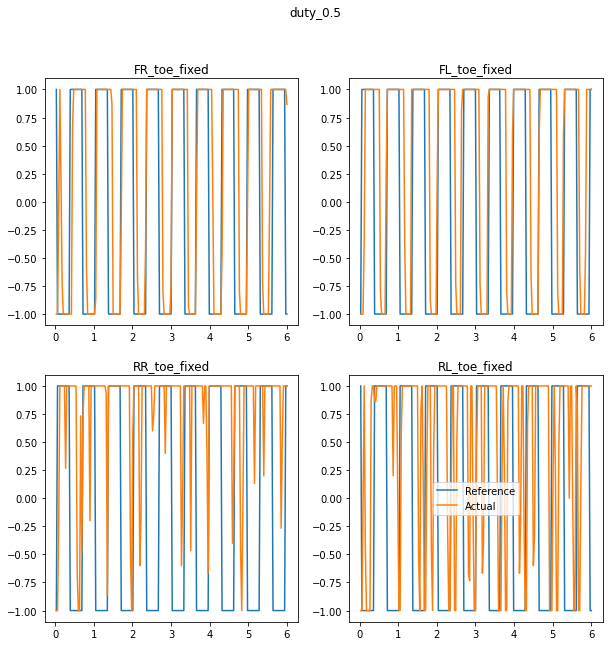

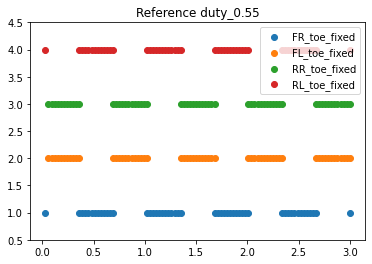

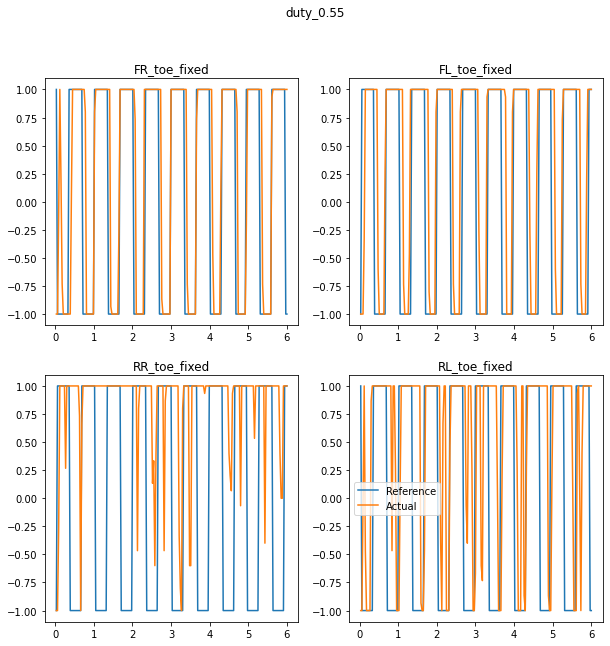

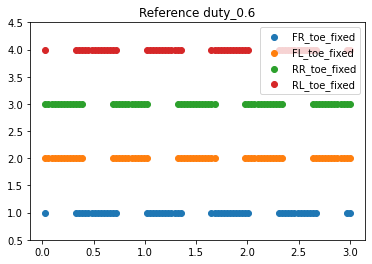

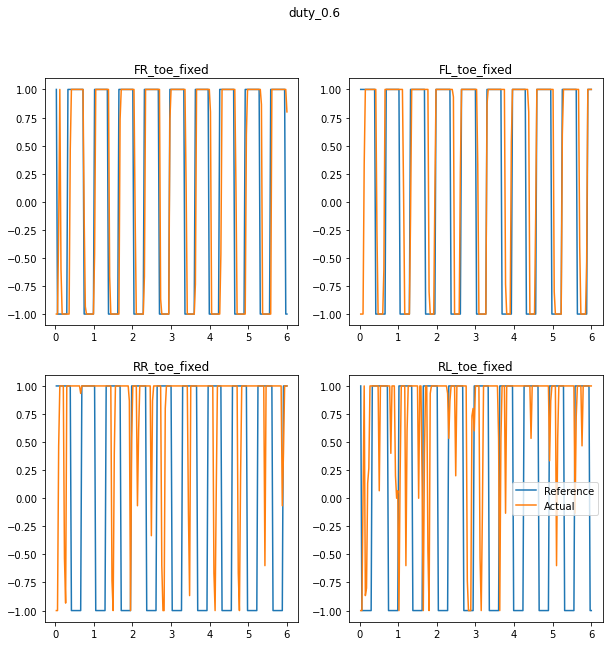

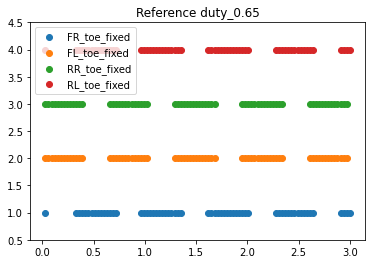

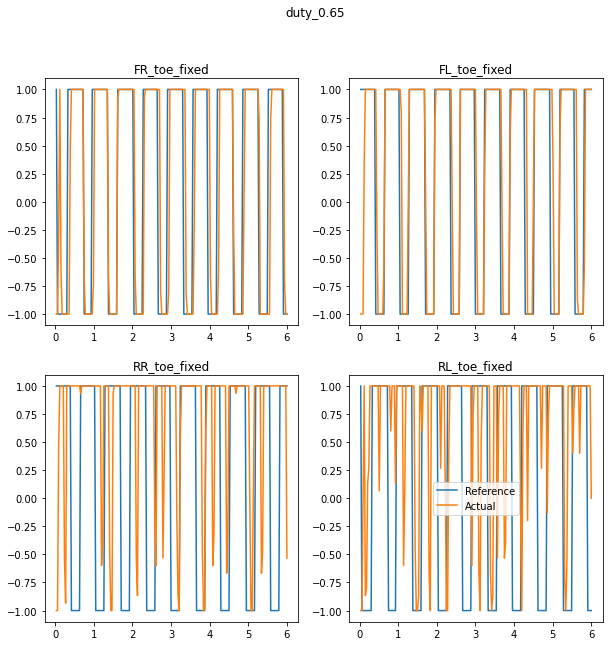

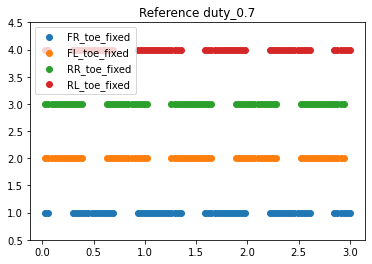

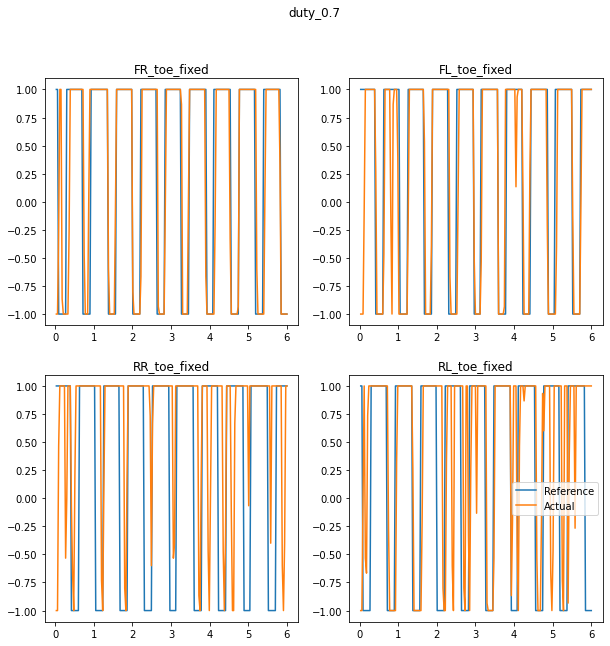

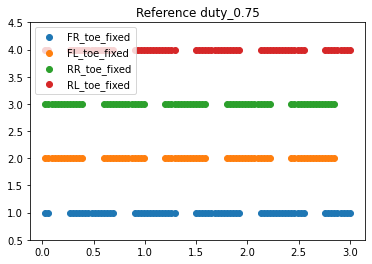

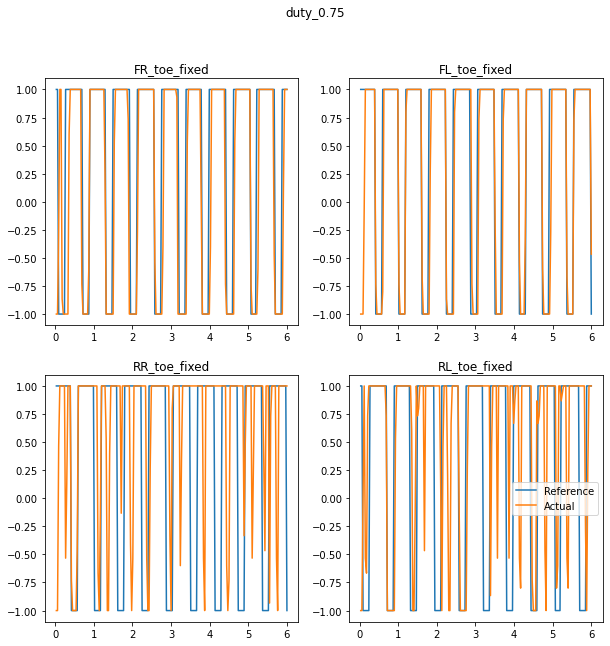

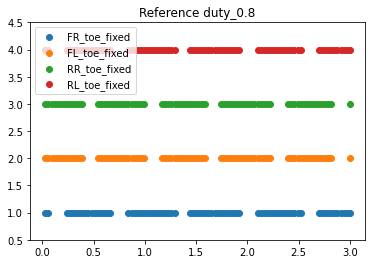

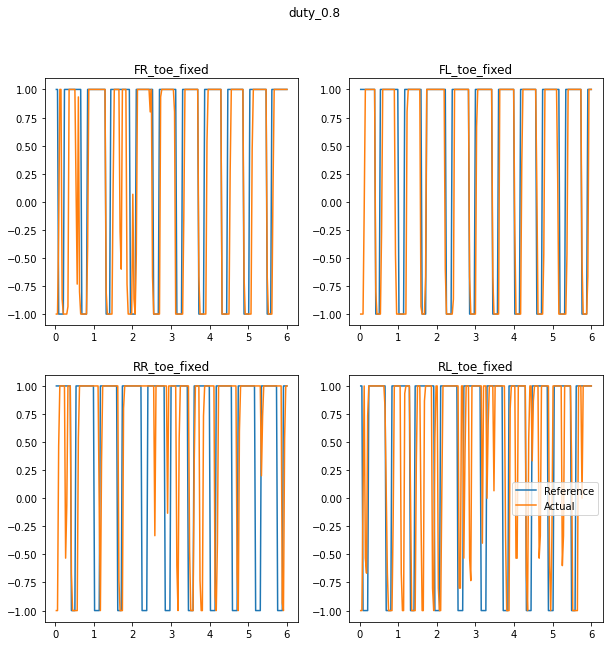

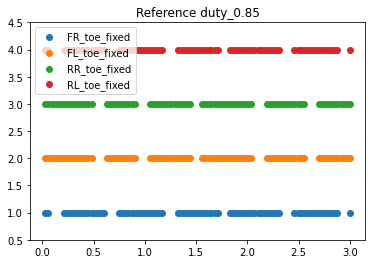

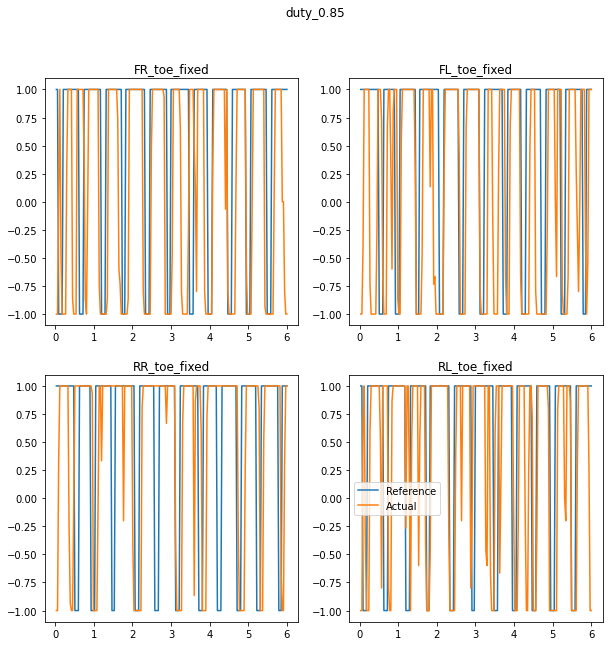

In [9]:
model_dir = project_dir / 'logs/trot_rew_fn_experiments' / 'ppo' / 'A1GymEnv-v0_8'
stats_dirs = [
    model_dir / 'test_var_duty' / f'duty_{duty}' \
        for duty in (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85)
]
# stats_dir1 = model_dir / 'experiments' / 'vary_freq' / 'train_1.0Hz_test_1.0Hz_alpha_10.0'
# stats_dir2 = model_dir / 'experiments' / 'vary_freq' / 'train_1.0Hz_test_2.0Hz'

statss = [load_robot_states(sd) for sd in stats_dirs]
normalizer = load_normalizer(model_dir)

def plot_foot_contact_sequence(stats, stats_dir, normalizer):
    import matplotlib.pyplot as plt 
    
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, -4:]
    act_foot_contacts = (0.03 - 2 * stats[3]) / 0.03
    # Every cycle will result in an overall +4 to the absolute difference of consec. terms
    num_cycles = np.sum(np.abs(ref_foot_contacts[:-1] - ref_foot_contacts[1:]), axis=0) / 4
    print(num_cycles)
    
    plt.figure()
    plt.title(f"Reference {stats_dir.name}")
    plt.ylim(0.5, 4.5)
    for i in range(4):    
        plt.scatter(time[:100], ref_foot_contacts[:100, i] * (i+1), label = foot_names[i])
    plt.legend()

    
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    fig.suptitle(stats_dir.name)
    idxes = [(0,0), (0,1), (1,0), (1,1)]
    for i in range(4):
        ax[idxes[i]].set_title(f"{foot_names[i]}")
        ax[idxes[i]].plot(time[:200], ref_foot_contacts[:200, i], label = 'Reference')
        ax[idxes[i]].plot(time[:200], act_foot_contacts[:200, i], label = 'Actual')
        plt.legend()

for stats, stats_dir in zip(statss, stats_dirs):
    plot_foot_contact_sequence(stats, stats_dir, normalizer)
    

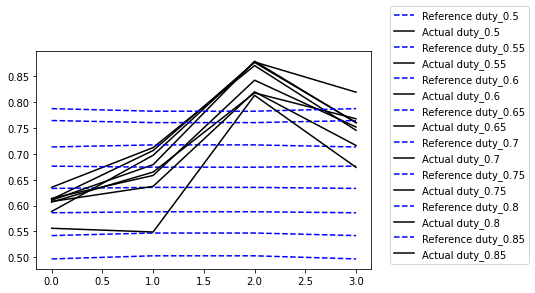

In [19]:
def measure_duty_factor(foot_contacts):
    """ Foot contact should be 1 for contact and -1 for non-contact"""
    foot_contacts = np.maximum(foot_contacts, 0)
    avg_contact_time = np.mean(foot_contacts, axis=0)
    return avg_contact_time

def plot_estimated_duty_factor(stats, name = ""):
    import matplotlib.pyplot as plt 
    
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, -4:]
    act_foot_contacts = (0.03 - 2 * stats[3]) / 0.03

    ref_measured_df = measure_duty_factor(ref_foot_contacts)
    act_measured_df = measure_duty_factor(act_foot_contacts)

    plt.plot(np.arange(4), ref_measured_df, c = 'blue', label=f"Reference {name}", linestyle='--')
    plt.plot(np.arange(4), act_measured_df, c = 'black', label=f"Actual {name}")
    

plt.figure()
for stats, stats_dir in zip(statss, stats_dirs):
    plot_estimated_duty_factor(stats, stats_dir.name)
plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left")

FR_toe_fixed 0.5396583964544304 1.1773140443316894e-76
FL_toe_fixed 0.5832133924615702 3.4894101338867e-92
RR_toe_fixed 0.13878051113120596 1.0604484064185647e-05
RL_toe_fixed 0.2646718962432859 1.71802495521293e-17

FR_toe_fixed 0.7119801956153776 2.0749102683224693e-155
FL_toe_fixed 0.6724003376895366 1.5040964493871697e-132
RR_toe_fixed 0.06591598218859118 0.03715050792011682
RL_toe_fixed 0.16509495271434538 1.5185273943539776e-07

FR_toe_fixed 0.7890229455154892 2.2575119366032214e-213
FL_toe_fixed 0.7519113307924286 8.854674194993106e-183
RR_toe_fixed -0.10553036077564569 0.000830794421695533
RL_toe_fixed 0.04539573428473113 0.15143440578398487

FR_toe_fixed 0.7935684749062984 1.5167853155867785e-217
FL_toe_fixed 0.7870848807278532 1.263187336007148e-211
RR_toe_fixed 0.05568455502666137 0.07839702540084276
RL_toe_fixed 0.23378450847013846 7.010812318826131e-14

FR_toe_fixed 0.8217084972796513 6.032464613363665e-246
FL_toe_fixed 0.8672224171259479 1.6985454232286681e-304
RR_toe_fix

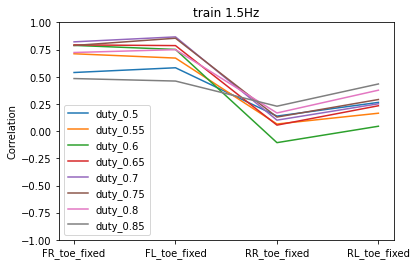

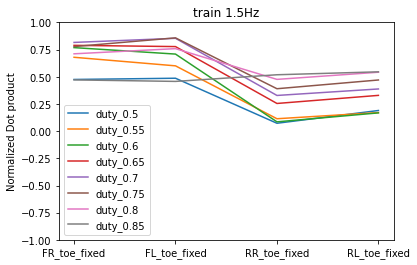

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def compute_correlation(stats, normalizer, ax, label=None):
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, -4:]
    act_foot_contacts = (0.03 - 2 * stats[3]) / 0.03
    corrs = np.zeros(4,)
    for i in range(4):
        corr, p = spearmanr(act_foot_contacts[:,i], ref_foot_contacts[:,i])
        print(foot_names[i], corr, p)
        corrs[i] = corr
    ax.plot(foot_names, corrs, label=label)

def compute_dot_prod(stats, normalizer, ax, label=None):
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, -4:]
    act_foot_contacts = (0.03 - 2 * stats[3]) / 0.03
    dot_prods = np.zeros(4,)
    for i in range(4):
        dot_prod = np.dot(act_foot_contacts[:,i], ref_foot_contacts[:,i])
        dot_prod = dot_prod / (ref_foot_contacts[:,i] ** 2).sum(axis=0) 
        print(foot_names[i], dot_prod)
        dot_prods[i] = dot_prod
    ax.plot(foot_names, dot_prods, label=label)
    
labels = [sd.name for sd in stats_dirs]

fig, ax = plt.subplots()
ax.set_ylim((-1.0, 1.0))

# labels = ['test_1.0Hz', 'test_1.5Hz', 'test_2.0Hz']
for i, stats in enumerate(statss):
    compute_correlation(stats, normalizer, ax, label = labels[i])
    print()
ax.set_title("train 1.5Hz")
ax.set_ylabel("Correlation")
ax.legend()

fig, ax = plt.subplots()
ax.set_ylim((-1.0, 1.0))
# labels = ['test_1.0Hz', 'test_1.5Hz', 'test_2.0Hz']
for i, stats in enumerate(statss):
    compute_dot_prod(stats, normalizer, ax, label = labels[i])
    print()
ax.set_title("train 1.5Hz")
ax.set_ylabel("Normalized Dot product")
ax.legend()